# 决策树

In [1]:
from sklearn.datasets import load_iris

# 加载数据集
iris = load_iris()

In [2]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
# 加载树模型
from sklearn.tree import DecisionTreeClassifier

In [4]:
treeClf = DecisionTreeClassifier(max_depth=5)

In [5]:
x,y = iris.data[:,:2],iris.target

In [6]:
treeClf.fit(x,y)

DecisionTreeClassifier(max_depth=5)

In [7]:
from sklearn.tree import export_graphviz

export_graphviz(
    treeClf,
    out_file="./result/iris_tree.dot",
    feature_names=iris["feature_names"][:2],
    class_names=iris["target_names"],
    rounded=True,
    filled=True
)

In [8]:
# 转换图像
! dot -Tpng ./result/iris_tree.dot -o ./result/iris_tree.png

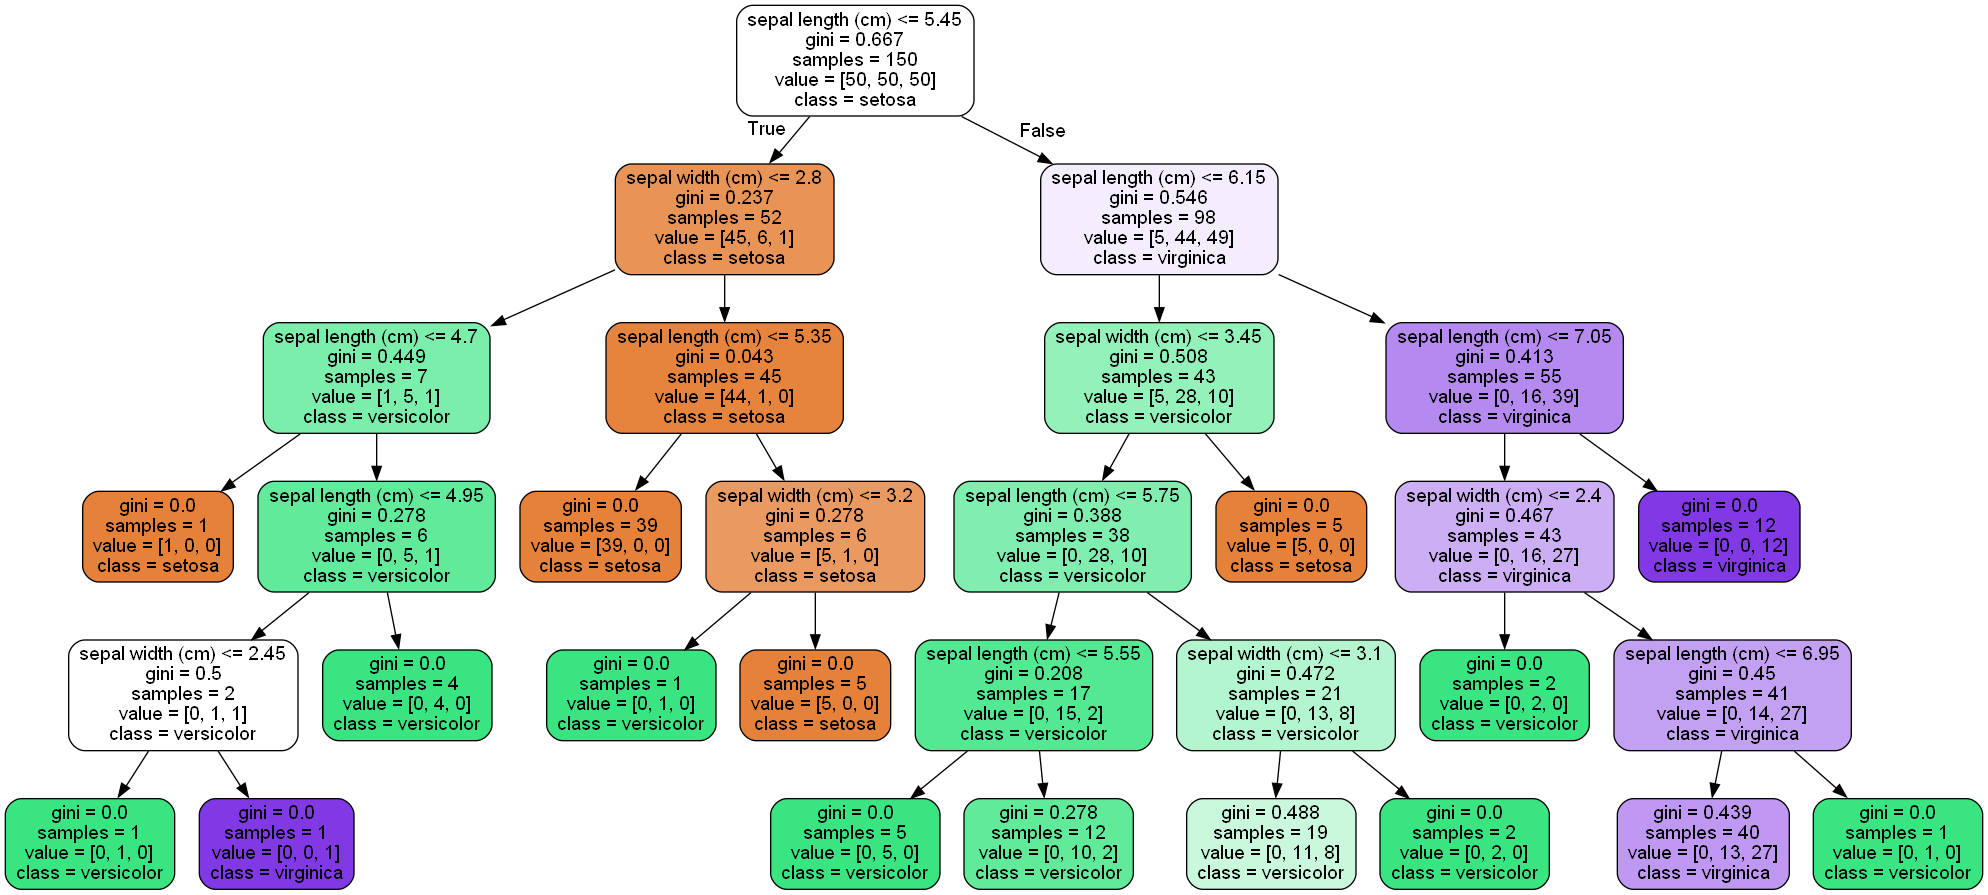

In [9]:
from IPython.display import Image
Image(filename="./result/iris_tree.png",width=800,height=800)

In [10]:
## 回归模型
from sklearn.tree import DecisionTreeRegressor

treeReg = DecisionTreeClassifier(max_depth=5)

In [11]:
import numpy as np

# 软投票和硬投票

## 概念
- 软投票看的是概率，支持某个概率特别高的分类器的决策行为
- 硬投票看的是结果，采取少数服从多数
  

In [12]:
import matplotlib.pyplot as plt

In [13]:
# 创建数据集
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

x,y = make_moons(n_samples=500,noise=0.3,random_state=52)
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42)

In [14]:
x.shape,y.shape

((500, 2), (500,))

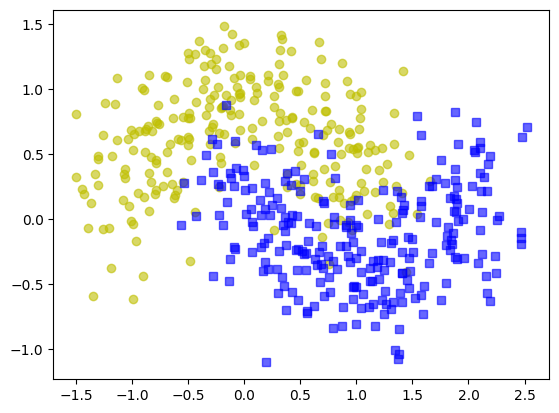

In [15]:
plt.plot(x[:,0][y==0],x[:,1][y==0],"yo",alpha=0.6)
plt.plot(x[:,0][y==1],x[:,1][y==1],"bs",alpha=0.6)

## 硬投票实验

In [16]:
# 导入集成学习的包
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

logClf = LogisticRegression(random_state=42)
randClf = RandomForestClassifier(random_state=42)
svmClf = SVC(random_state=42)
votingClf = VotingClassifier(estimators=[("lr",logClf),("rf",randClf),("svm",svmClf)],voting="hard")

In [17]:
y_train.shape

(375,)

In [18]:
votingClf.fit(x_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(random_state=42))])

In [19]:
from sklearn.metrics import accuracy_score

for es in (logClf,randClf,svmClf,votingClf):
    es.fit(x_train,y_train)
    y_pre = es.predict(x_test)
    ac = accuracy_score(y_true=y_test,y_pred=y_pre)
    print(es.__class__.__name__,":",ac)

LogisticRegression : 0.84
RandomForestClassifier : 0.904
SVC : 0.92
VotingClassifier : 0.92


## 软投票实验

In [20]:
# 导入集成学习的包
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

logClf = LogisticRegression(random_state=42)
randClf = RandomForestClassifier(random_state=42)
svmClf = SVC(random_state=42)
votingClf = VotingClassifier(estimators=[("lr",logClf),("rf",randClf),("svm",svmClf)],voting="hard")

In [21]:
from sklearn.metrics import accuracy_score

for es in (logClf,randClf,svmClf,votingClf):
    es.fit(x_train,y_train)
    y_pre = es.predict(x_test)
    ac = accuracy_score(y_true=y_test,y_pred=y_pre)
    print(es.__class__.__name__,":",ac)

LogisticRegression : 0.84
RandomForestClassifier : 0.904
SVC : 0.92
VotingClassifier : 0.92


# bagging

## 训练策略
- 首先对训练数据进行多次采样，保证每次得到的采样数据都是不同的
- 分别训练多个模型，例如：树模型
- 预测试需要得到所有模型的结果在进行集成

In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagCls = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    max_samples=100,
    random_state=42,
    n_jobs=-1
)
bagCls.fit(x_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [23]:
accuracy_score(y_test,bagCls.predict(x_test))

0.928

In [24]:
treeClf = DecisionTreeClassifier(random_state=42)
treeClf.fit(x_train,y_train)
accuracy_score(y_test,treeClf.predict(x_test))

0.848

In [25]:
# 绘制决策边界--目前只能用到二维
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf,x,y,axes=[-1.5,2.5,-1,1.5],alpha = 0.8, contour = True):
    # 将坐标轴进行切分
    x1s = np.linspace(axes[0],axes[1],100)
    x2s = np.linspace(axes[2],axes[3],100)
    # 按照切分的结果，在坐标轴画线，会形成单元格，下面分别获取单元格的左下角坐标
    # [[1,2],[3,4]] -> x1 = [[1,2],[1,2]],x2 = [[3,3],[4,4]]
    x1,x2 = np.meshgrid(x1s,x2s)
    # 下面再将划分的坐标分别拉平，组成一系列的点，做为样本点
    # 一共的样本点是 100*100个
    x_new = np.c_[x1.ravel(),x2.ravel()]
    # 对样本点进行分类
    y_pred = clf.predict(x_new).reshape(x1.shape)
    # 根据预测结果，涂颜色
    # 根据等值信息填充，若一个区域的值相等，则填充同一种颜色
    cusCMap = ListedColormap(["#1f77b4","#ff7f0e","#2ca02c"]) # 色谱
    plt.contourf(x1,x2,y_pred,cmap = cusCMap,alpha = 0.3)
    if contour: # 是否绘制等值线
        # 下面绘制等值线，类似于山峰的等高线
        plt.contour(x1,x2,y_pred,cmap = cusCMap,alpha=alpha) 
    # 再放上真是的结果
    plt.plot(x[:,0][y==0],x[:,1][y==0],"yo",alpha=0.8)
    plt.plot(x[:,0][y==1],x[:,1][y==1],"bs",alpha=0.8)
    # 坐标范围
    plt.axis(axes)
    plt.xlabel("x1")
    plt.xlabel("x2")

Text(0.5, 1.0, 'decision Tree with bagging')

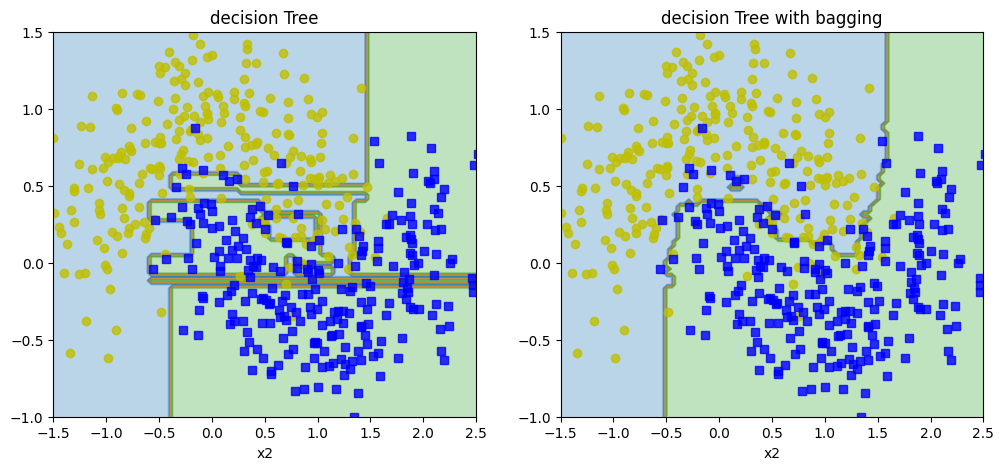

In [26]:
plt.figure(figsize=(12,5))
# 左边的子图
plt.subplot(121)
#决策树
plot_decision_boundary(treeClf,x,y,alpha=0.3)
plt.title("decision Tree")
# 右边的子图
plt.subplot(122)
#决策树
plot_decision_boundary(bagCls,x,y,alpha=0.3)
plt.title("decision Tree with bagging")

## OOB策略->out of bag

1.  一种将随机策略下未选中的样本，作为验证集的策略

In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bagClf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    max_samples=100,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)
bagClf.fit(x_train,y_train)
bagClf.oob_score_ # 查看验证集的结果

0.8853333333333333

In [147]:
y_pred = bagCls.predict(x_test)
accuracy_score(y_test,y_pred)

0.928